# Import the Required Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import load_model
import random 
import os
import matplotlib.pyplot as plt

# Prepare Training Data

**Unzip the compressed folder**

In [2]:
def extract_files(source_path, target_path):
    zip_ref = zipfile.ZipFile(source_path,'r')  #Read compressed files
    zip_ref.extractall(target_path) #Unzip all pictures in the folder to the specified location
    zip_ref.close()

In [ ]:
extract_files(r'C:\Users\11409\Desktop\AMLS2/kaggle/input/test1.zip',r'C:\Users\11409\Desktop\AMLS2/kaggle/working/')
extract_files(r'C:\Users\11409\Desktop\AMLS2/kaggle/input/train.zip',r'C:\Users\11409\Desktop\AMLS2/kaggle/working/')

**Extract labels according to the file names.**

In [3]:
filenames = os.listdir(r'C:\Users\11409\OneDrive - University College London\Desktop\AMLS2\kaggle/working/train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('1')
    else:
        categories.append('0')
df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [ ]:
df.to_csv(r'C:\Users\11409\OneDrive - University College London\Desktop\AMLS2\kaggle/working/train_label.csv',index = False)

In [4]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [5]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


# See Total In Count

<AxesSubplot:>

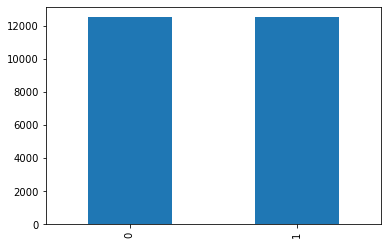

In [6]:
df['category'].value_counts().plot.bar()

In [7]:
df['category'].value_counts()

0    12500
1    12500
Name: category, dtype: int64

From the data set, there are 12500 cats and 12500 dogs

# See sample image 

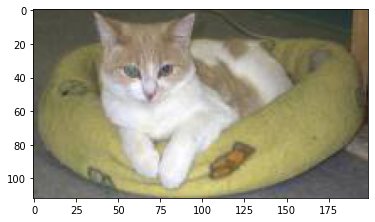

In [9]:
sample = random.choice(filenames)
image = load_img(r'C:\Users\11409\OneDrive - University College London\Desktop\AMLS2\kaggle/working/train/'+sample)
plt.imshow(image)

# Define Constants

In [10]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Buid Custom CNN Model

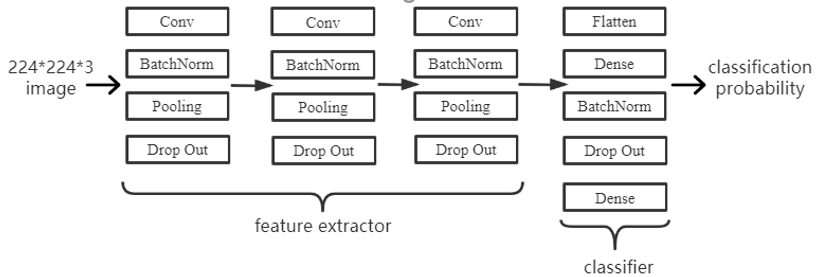

In [11]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))
          
model.compile(optimizer='Adam', metrics = ['accuracy'],loss = 'binary_crossentropy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

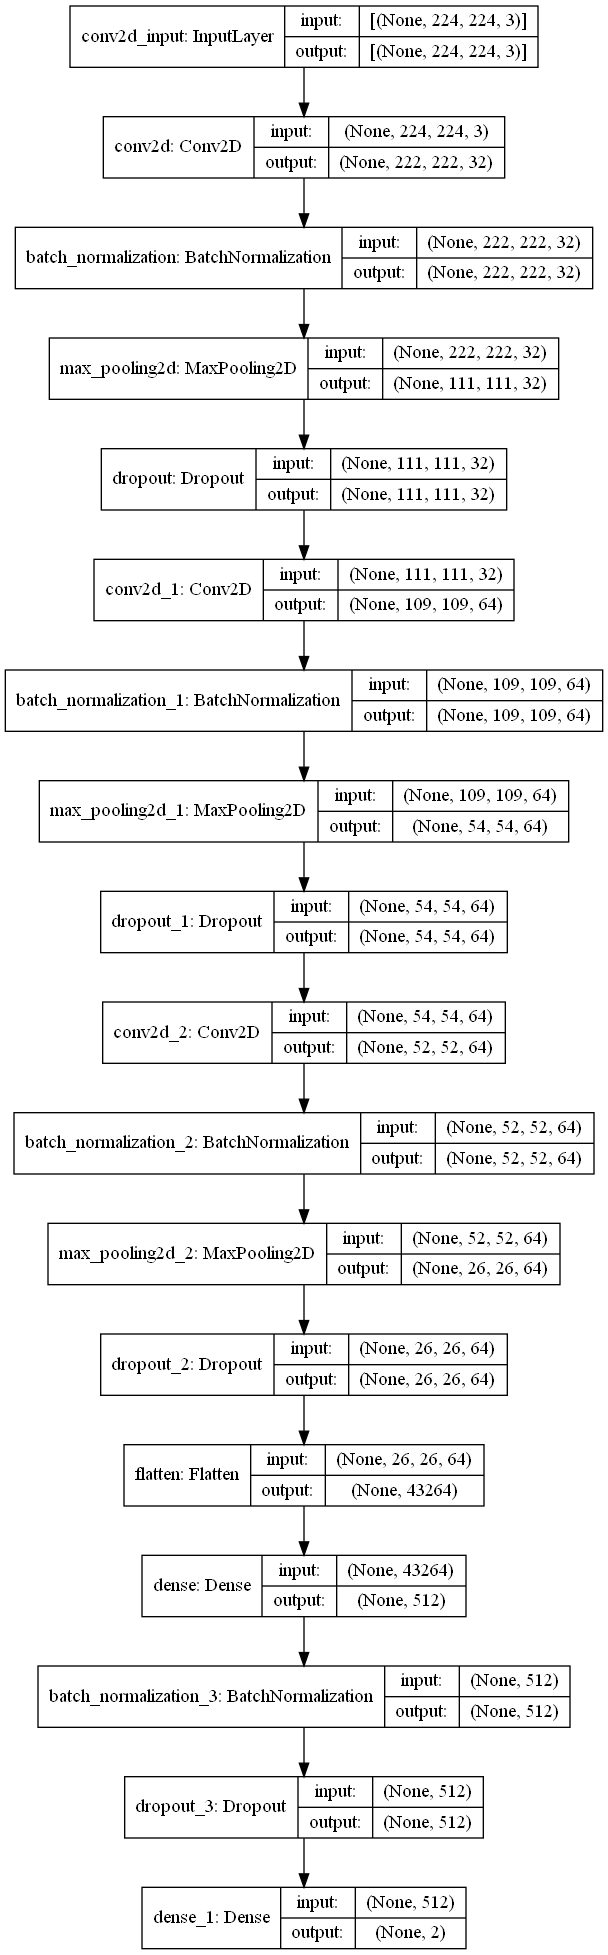

In [12]:
import pydot
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

# Callbacks

**Early Stop**


Calculate the performance of the model on the validation set during training. When the performance of the model on the validation set begins to decline, stop training.

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 3)

**Learning Rate Reduction**

detects that whether the model's performance reaches a plateau, it will adjust the learning rate to suit the learning. 

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',
                                           patience = 2,
                                           verbose = 1,
                                           factor = 0.5,
                                           min_lr = 1e-5)

In [15]:
callbacks = [earlystop,learning_rate_reduction]

# Prepare Data

Separate the training set and validation set, the ratio is 8:2

In [17]:
train_df, validate_df = train_test_split(df,test_size=0.2,random_state=0)

Get the number of images in the training set and validation set

In [33]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [18]:
train_df=train_df.reset_index()
validate_df = validate_df.reset_index()

# Train Generator

In [19]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                  rescale=1./255,
                                  shear_range = 0.1,
                                    zoom_range = 0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                  )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                   r'C:\Users\11409\OneDrive - University College London\Desktop\AMLS2\kaggle\working\train/',
                                                   x_col='filename',
                                                   y_col='category',
                                                   target_size=IMAGE_SIZE,
                                                   class_mode='categorical',
                                                   batch_size=10)

Found 20000 validated image filenames belonging to 2 classes.


# Validation Generator

In [20]:
validate_datagen = ImageDataGenerator(rescale=1./255)
validate_generator = validate_datagen.flow_from_dataframe(validate_df,
                                                         r'C:\Users\11409\OneDrive - University College London\Desktop\AMLS2\kaggle\working\train/',
                                                         x_col='filename',
                                                         y_col='category',
                                                         target_size=IMAGE_SIZE,
                                                         class_mode='categorical',
                                                         batch_size = 10
                                                         )

Found 5000 validated image filenames belonging to 2 classes.


# See the data augmentation example

In [50]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(example_df,
                                                     r'C:\Users\11409\OneDrive - University College London\Desktop\AMLS2\kaggle\working\train/',
                                                     x_col='filename',
                                                   y_col='category',
                                                   target_size=IMAGE_SIZE,
                                                   class_mode='categorical',
                                                batch_size=10
                                                     )

Found 1 validated image filenames belonging to 1 classes.


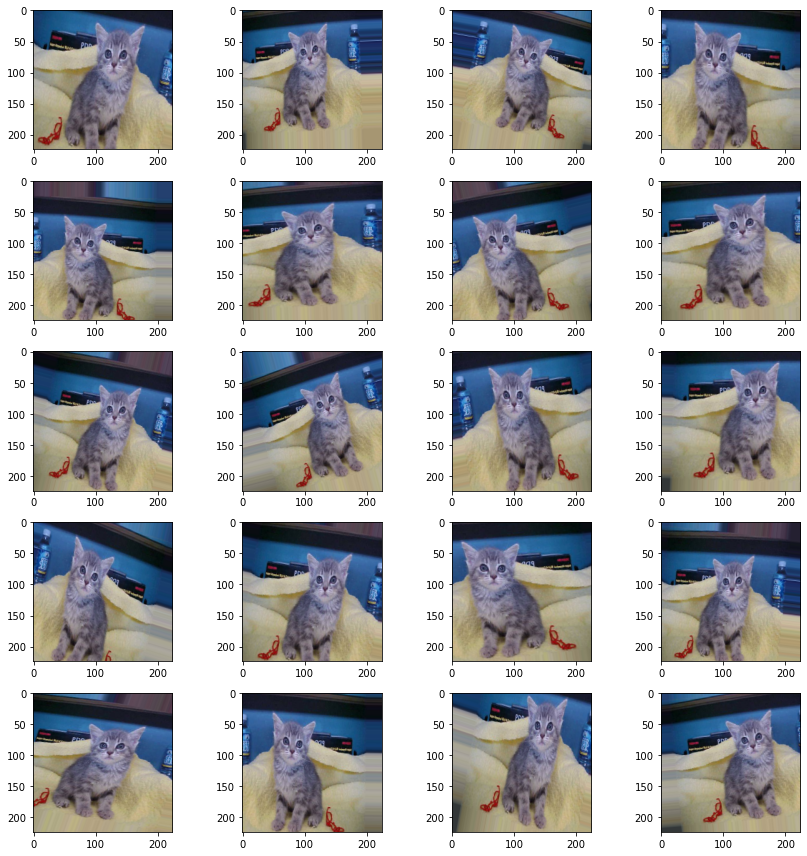

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
for i in range(20): 
    plt.subplot(5,4,i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit the Custom Model

In [ ]:
epochs = 10
batch_size = 10
history_custom = model.fit(train_generator,
                   epochs = epochs,          
                    validation_data = validate_generator,
                   validation_steps = total_validate//batch_size,
                   steps_per_epoch = total_train//batch_size,
                   callbacks = callbacks)

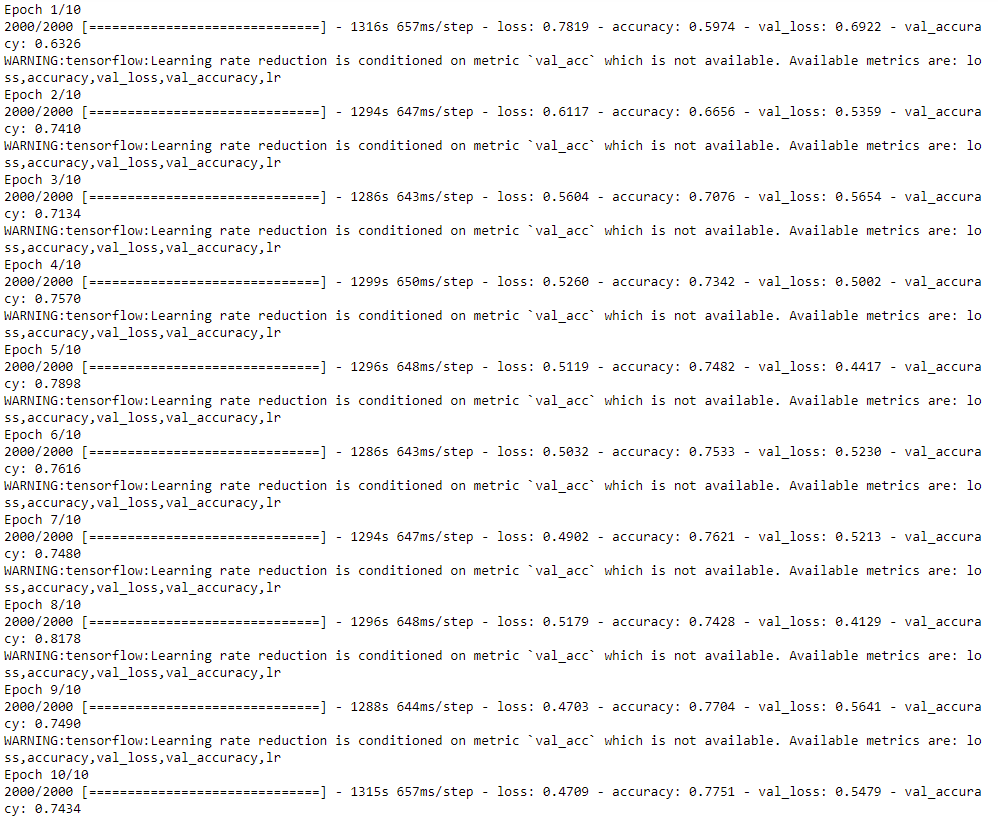

**Save Model**

In [31]:
model.save(r"C:\Users\11409\Desktop\AMLS2/kaggle/model_zi_10_adam.h5")

# Learning Curve

Plot the learning curves, and judge the performance of the model by drawing the accuracy of the training set and the validation set

In [36]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
plot_model_history(history_custom)

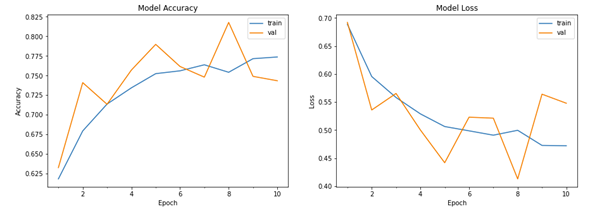

# Testing

**Prepare testing data**

In [37]:
test_filenames = os.listdir(r'C:\Users\11409\OneDrive - University College London\Desktop\AMLS2\kaggle\working\test\all')
test_categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        test_categories.append(1)
    else:
        test_categories.append(0)
test_df = pd.DataFrame({
    'test_filename':test_filenames,
    'test_category':test_categories
})
nb_samples = test_df.shape[0]
test_df.reset_index(drop=True)
test_df['test_category']=test_df['test_category'].astype(str)

**Create testing generator**

In [38]:
test_gen = ImageDataGenerator(rescale=1./255)
batch_size = 10
test_generator = test_gen.flow_from_dataframe(test_df,
                                             r'C:\Users\11409\OneDrive - University College London\Desktop\AMLS2\kaggle\working\test\all',
                                             x_col='test_filename',
                                             y_col='test_category',
                                             class_mode = 'categorical',
                                             target_size = IMAGE_SIZE,
                                             batch_size = batch_size,
                                             shuffle=False)

Found 2000 validated image filenames belonging to 2 classes.


**evaluate the model on test set; get the test loss and accuracy**

In [ ]:
model1.evaluate(test_generator,verbose = 1)

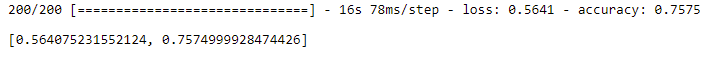

# Pedict

In [ ]:
y_pred=model1.predict(test_generator)

**Draw classification reports to get various metrics**

In [39]:
def report(y_pred,y_final):
    threshold = 0.5
    y_pred_class = np.where(y_pred > threshold, 1,0)
    y_pred_class = [x[1] for x in y_pred_class]
    y_true=list(map(int,y_final['test_category']))
    report = classification_report(y_true, y_pred_class)
    print(report)

In [ ]:
report(y_pred,test_df)

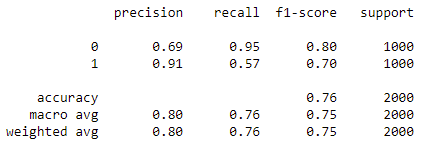

# VGG16 with Fine tuning

In [41]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalMaxPooling2D
from keras import layers
from keras.models import Model
from keras import optimizers

In [52]:
pre_trained_model = VGG16(input_shape=(224,224,3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

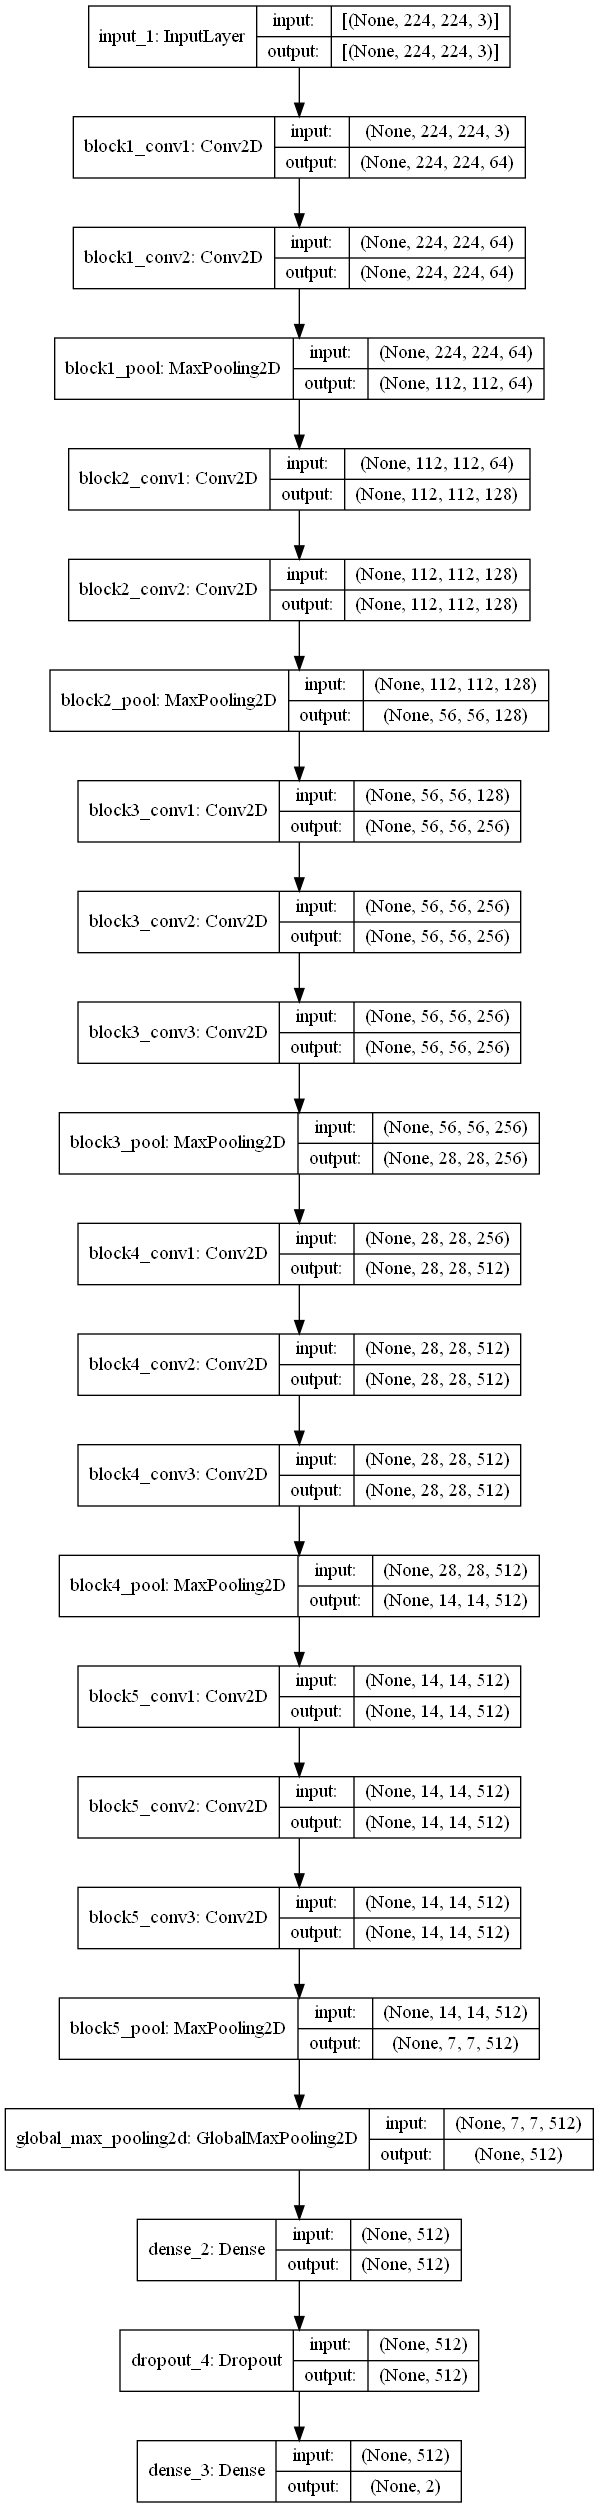

In [43]:
keras.utils.plot_model(model, "multi_input_and_output_model_vgg.png", show_shapes=True)

In [ ]:
batch_size = 10
history_vgg = model.fit(
    train_generator,
    epochs=5,
    validation_data=validate_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks = callbacks)

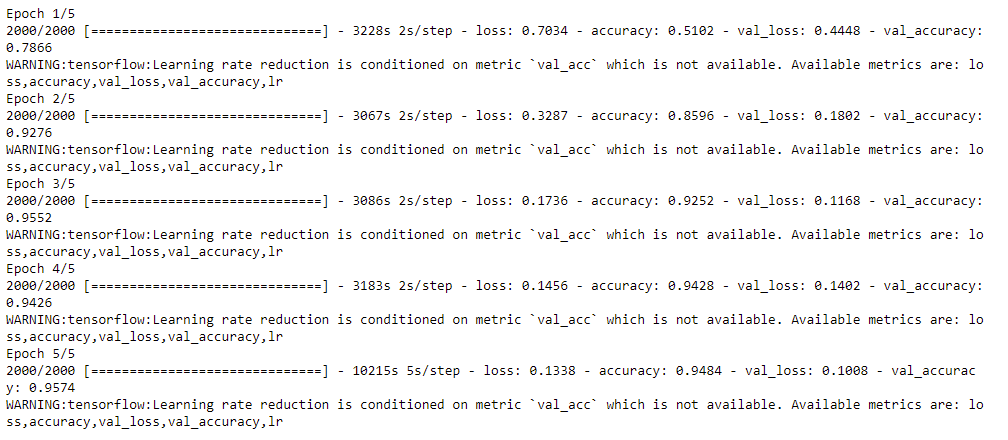

In [ ]:
model.save(r"C:\Users\11409\Desktop\AMLS2/kaggle/model_vgg_5_rmsprop.h5")

In [ ]:
plot_model_history(history_vgg)

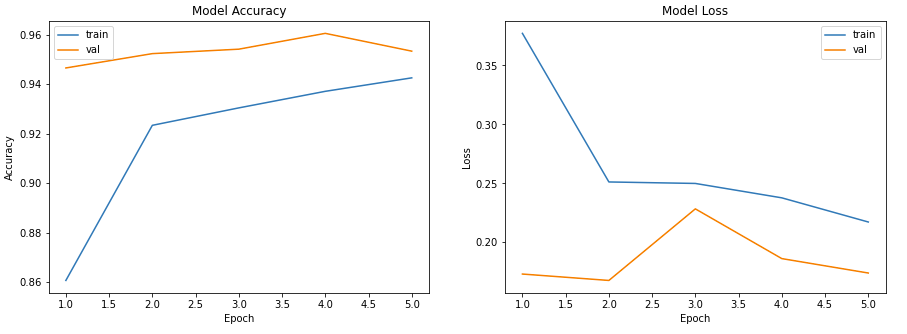

In [ ]:
model.evaluate(test_generator,verbose = 1)

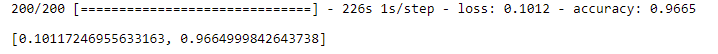

In [ ]:
y_pred=model.predict(test_generator)

In [ ]:
report(y_pred,test_df)

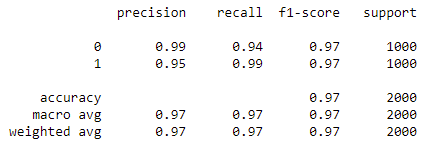